In [ ]:
from pylab import *
import random_idx
from __future__ import division
import scipy
import time

%matplotlib inline

plt.rcParams.update({'axes.titlesize': 'xx-large'})
plt.rcParams.update({'axes.labelsize': 'xx-large'})
plt.rcParams.update({'xtick.labelsize': 'x-large', 'ytick.labelsize': 'x-large'})
plt.rcParams.update({'legend.fontsize': 'x-large'})


## Theory

First here are the functions to describe the theory of the capacity.

In [ ]:
def ncdf(z):
    return 0.5 * (1 + scipy.special.erf(z/2**0.5))

def p_correct_l(M, N=10000, D=27, ares=2000):
    M = np.array(M)
    p = np.zeros((ares-1, len(M)))

    for iM,Mval in enumerate(M):
        avals = np.linspace(N - 8 * (N*Mval)**0.5, N + 8 * (N*Mval)**0.5, ares)
        
        p[:, iM] = ncdf((avals[1:]-N) / ((Mval-1)*N)**0.5) - ncdf((avals[:-1]-N) / ((Mval-1)*N)**0.5)
        p[:, iM] *= (ncdf(np.mean(np.vstack((avals[1:], avals[:-1])), axis=0)/(Mval*N)**0.5)) ** (D-1)

    return np.sum(p, axis=0)

In [ ]:
def p_hit(M, N=10000, D=27, reject_thresh=0.5, ares=2000):
    M = np.array(M)
    p = np.zeros((ares-1, len(M)))

    for iM,Mval in enumerate(M):
        avals = np.linspace(reject_thresh * N, N + 8 * (N*Mval)**0.5, ares)
        
        p[:, iM] = ncdf((avals[1:]-N) / ((Mval-1)*N)**0.5) - ncdf((avals[:-1]-N) / ((Mval-1)*N)**0.5)
        p[:, iM] *= (ncdf(np.mean(np.vstack((avals[1:], avals[:-1])), axis=0)/(Mval*N)**0.5)) ** (D-1)

    return np.sum(p, axis=0)

# This is wrong for now;
#def p_corr_rej(M, N=10000, reject_thresh=0.5, ares=2000):
#    M = np.array(M)
#    p = np.zeros((ares-1, len(M)))#
#
#    for iM,Mval in enumerate(M):
#        avals = np.linspace(N - 8 * (N*Mval)**0.5, N * reject_thresh, ares)
#        
#        p[:, iM] = ncdf((avals[1:]-N) / ((Mval-1)*N)**0.5) - ncdf((avals[:-1]-N) / ((Mval-1)*N)**0.5)
#        p[:, iM] *= (ncdf(np.mean(np.vstack((avals[1:], avals[:-1])), axis=0)/(Mval*N)**0.5)) ** (D-1)
#
#    return np.sum(p, axis=0)

## HRR in Frequency Domain

This requires the representation of complex numbers. Instead of relying on complex numbers in code, \citet{Dinihelka2016} and others rely on a special vector that has twice as many elements, where the first half represent the real values and the second half represents the imaginary values. This makes it have twice as many numbers for the same N, but the elements are potentially richer. 

First, here are a set of functions that implement the necessary algebra:

In [ ]:
def fhrr_vec(D, N):
    # pick a random phase
    rphase = 2 * np.pi * np.random.rand(D, N // 2)

    fhrrv = np.zeros((D, 2 * (N//2)))
    fhrrv[:, :(N//2)] = np.cos(rphase)
    fhrrv[:, (N//2):] = np.sin(rphase)
    
    return fhrrv

def fhrr_inv(a):
    N2 = a.shape[1] // 2
    b = np.zeros_like(a)
    b[:,:N2] = a[:, :N2]
    b[:,N2:] = -a[:, N2:]
    
    return b

def fhrr_bind(a, b):
    # we want to do element wise multiply of complex numbers
    N2 = a.shape[1] // 2
    
    ra = a[:, :N2]
    ia = a[:, N2:]
    rb = b[:, :N2]
    ib = b[:, N2:]
    
    c = np.zeros_like(a)
    
    c[:, :N2] = ra * rb - ia * ib
    c[:, N2:] = ra * ib + rb * ia
    
    return c
    
def fhrr_roll(a, r=1):
    N2 = a.shape[1] // 2
    c = np.zeros_like(a)
    c[:, :N2] = np.roll(a[:, :N2], r, axis=1)
    c[:, N2:] = np.roll(a[:, N2:], r, axis=1)
    
    return c

In [ ]:
N = 10000
M = 100
D = 27

x = linspace(-8*N*M, 8*N*M, 10000)

h_pdf = exp(-(N-x)**2/(2*N*(M-1)))
r_pdf = exp(-x**2/(2*N*M))

plot(x, h_pdf)
plot(x, r_pdf)

Next we can see the results of the binding operations and decoding the binding:

In [ ]:
N = 10000

a = fhrr_vec(1, N)
b = fhrr_vec(1, N)
c = fhrr_bind(a, b)

binv = fhrr_inv(b)
a2 = fhrr_bind(binv, c)

d = fhrr_roll(c)
ainv = fhrr_inv(a)
e = fhrr_roll(d, -1) 
b2 = fhrr_bind(ainv, e)

print "a . a: ", np.dot(a, a.T)
print "a . b: ", np.dot(a, b.T)
print "a . c: ", np.dot(a, c.T)
print "a . ainv: ", np.dot(a, ainv.T)
print "c . d: ", np.dot(c, d.T)
print "b . b2: ", np.dot(b, b2.T)
print "binv . b2: ", np.dot(binv, b2.T)
print "a . a2: ", np.dot(a, a2.T)

In [ ]:
N = 10000

a = 2 * (np.random.randn(1, N) < 0) - 1
b = 2 * (np.random.randn(1, N) < 0) - 1
c = a * b

a2 = c * b

d = np.roll(c, 1)
e = np.roll(d, -1) 
b2 = e * a

print "a . a: ", np.dot(a, a.T)
print "a . b: ", np.dot(a, b.T)
print "a . c: ", np.dot(a, c.T)
print "a . ainv: ", np.dot(a, ainv.T)
print "c . d: ", np.dot(c, d.T)
print "b . b2: ", np.dot(b, b2.T)
print "a . a2: ", np.dot(a, a2.T)

binding and unbinding gives dot products still equal to $N=10000$.


In [57]:
def test_capacity_fhrr(N, D, K=5, trials=5e3):
    letter_vectors = fhrr_vec(D, N)

    bind_vec = fhrr_vec(1, N)

    tstart = time.time()
    lidx = np.zeros(trials)
    lidx[0] = np.random.randint(D)
    
    hypercapacity = fhrr_bind(bind_vec, letter_vectors[lidx[0]:(lidx[0]+1), :])

    lidx_last_input = np.zeros(trials)
    lidx_input_K = np.zeros(trials)
    lidx_first_input = np.zeros(trials)

    for i in range(int(trials)-1):
        lidx[i+1] = np.random.randint(D)
        
        lv = letter_vectors[lidx[i+1]:(lidx[i+1]+1), :]
        
        #bind_vec = fhrr_roll(bind_vec)
        #hypercapacity += fhrr_bind(bind_vec, lv)
        hypercapacity = fhrr_bind(bind_vec, hypercapacity) + lv
        
        v_last_input = fhrr_bind(fhrr_inv(bind_vec), hypercapacity)
        v_input_K = fhrr_bind(fhrr_inv(fhrr_roll(bind_vec, -K)), hypercapacity)
        v_first_input = fhrr_bind(fhrr_inv(fhrr_roll(bind_vec, -(i+1))), hypercapacity)
        
        lidx_last_input[i] = argmax(np.dot(letter_vectors, v_last_input.T))
        lidx_input_K[i] = argmax(np.dot(letter_vectors, v_input_K.T))
        lidx_first_input[i] = argmax(np.dot(letter_vectors, v_first_input.T))

    print 'Duration: ', time.time() - tstart
    
    return lidx, lidx_last_input, lidx_input_K, lidx_first_input

In [58]:
#test_N = [100, 200, 500]
test_N = [1000, 2000, 4000, 8000, 16000]
runs = 5

run_id = []
run_N = []
lidx_all = []
lidx_li_all = []
lidx_iK_all = []
lidx_fi_all = []

for r in range(runs):
    print r
    for N in test_N:
        lidx, lidx_li, lidx_iK, lidx_fi = test_capacity_fhrr(N, len(random_idx.alphabet))
        
        run_id.append(r)
        run_N.append(N)
        lidx_all.append(lidx)
        lidx_li_all.append(lidx_li)
        lidx_iK_all.append(lidx_iK)
        lidx_fi_all.append(lidx_fi)
        
filename = 'data/hypervector_capacity-fhrr_bind-N=' + str(len(test_N)) + '-r=' + str(runs) + '-n' + time.strftime('%y%m%d') + '.npz'
print filename
np.savez(filename, lidx_all=lidx_all, lidx_li_all=lidx_li_all, lidx_iK_all=lidx_iK_all, lidx_fi_all=lidx_fi_all,
        run_id=run_id, run_N=run_N, runs=runs, test_N=test_N)

0
Duration:  0.925704956055
Duration:  1.08581495285
Duration:  1.57040190697
Duration:  2.27468109131
Duration:  3.87268185616
1
Duration:  0.844992876053
Duration:  1.07541298866
Duration:  1.52454209328
Duration:  2.27100586891
Duration:  3.98509192467
2
Duration:  0.878874063492
Duration:  1.11277699471
Duration:  1.43093585968
Duration:  2.2318341732
Duration:  3.82075309753
3
Duration:  0.840428829193
Duration:  1.05525493622
Duration:  1.489164114
Duration:  2.2425699234
Duration:  3.85446596146
4
Duration:  0.862673997879
Duration:  1.04575514793
Duration:  1.47198605537
Duration:  2.22313213348
Duration:  3.90336704254
data/hypervector_capacity-fhrr_bind-N=5-r=5-n160515.npz


/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:19: Depr

In [60]:
K=5
run_id = np.array(run_id)
run_N = np.array(run_N)

uN = unique(run_N)

li_mean = np.zeros((lidx_li_all[0].shape[0], len(uN)))
iK_mean = np.zeros((lidx_iK_all[0].shape[0], len(uN)))
fi_mean = np.zeros((lidx_fi_all[0].shape[0], len(uN)))

for iN, idxN in enumerate(uN):
    idxs = find(run_N==idxN)
    for i in idxs:
        li_mean[:,iN] += np.array(lidx_all[i] == lidx_li_all[i], 'int32')
        iK_mean[:,iN] += np.array(lidx_all[i] == roll(lidx_iK_all[i], -K+1), 'int32')  
        fi_mean[:,iN] += np.array(lidx_all[i][0] == lidx_fi_all[i], 'int32')
    
li_mean = li_mean / runs
iK_mean = iK_mean / runs
fi_mean = fi_mean / runs


(0, 5000)

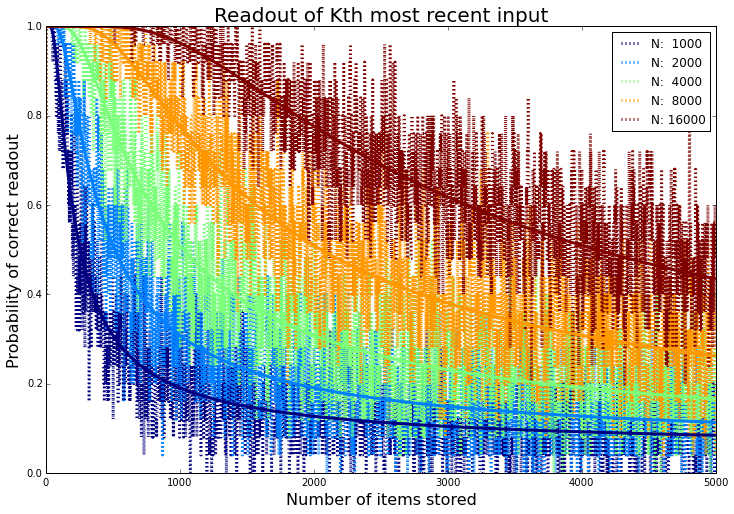

In [61]:

uN = unique(run_N)

figure(figsize=(12,8))
cm=get_cmap('jet', li_mean.shape[1])

for i in range(li_mean.shape[1]):
    #plot(li_mean[:,i], color=cm(i))
    smoothN = 5
    plot(np.convolve(li_mean[:,i], np.ones(smoothN)/smoothN, mode='same'), ':', color=cm(i), lw=3, label="N: %5i" % test_N[i])
    

M = np.arange(1, 5000,10)
 #Phi(z) = 1/2[1 + erf(z/sqrt(2))]
for idxN,N in enumerate(test_N):
    p_correct = p_correct_l(M, N=N, D=len(random_idx.alphabet))
    plot(M, p_correct, color=cm(idxN),lw=3)

legend(loc='upper right');
title('Readout of Kth most recent input', fontsize=20);
xlabel('Number of items stored', fontsize=16);
ylabel('Probability of correct readout', fontsize=16)

xlim([0, 5000])
        